# Requirements for this notebook:
1. Internet connection (to download corpora and tokenizer data with calls to nltk.download())
2. The following packages:
  1. nltk (Anaconda or PIP command line install : pip install -U nltk OR conda install nltk)
  2. gensim (pip install -U gensim)
  3. scikit-learn v0.18.1 (pip install -U scikit-learn)
  4. matplotlib (pip install -U matplotlib)
  5. numpy (pip install -U numpy)

# Objectives of this notebook are to illustrate how we can do the following with word embeddings:
1. Train from scratch
2. Explore embeddings vectors
3. Use these for an NLP task

In [1]:
import os
import pickle
import time
import logging
from collections import defaultdict

# NLTK page : http://www.nltk.org/

In [2]:
import nltk
nltk.__version__

'3.2.3'

# Gensim page : https://radimrehurek.com/gensim/index.html

In [3]:
import gensim
gensim.__version__

c:\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


'3.4.0'

# Scikit-learn page : http://scikit-learn.org/stable/

In [50]:
import sklearn
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import FeatureUnion
sklearn.__version__

'0.19.1'

In [5]:
import numpy as np
np.__version__

'1.14.0'

In [6]:
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline

In [8]:
from gensim.models import Word2Vec

In [9]:
%time nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
Wall time: 1.31 s


True

In [10]:
%time nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Wall time: 93.1 ms


True

In [11]:
%time nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
Wall time: 33 ms


True

In [12]:
# Let's download the PUNKT tokenizer first so that we can use tokenize words and sentences
%time nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Wall time: 30 ms


True

In [13]:
# Let's download stopwords so we can plot them later
%time nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Wall time: 7.01 ms


True

In [14]:
from nltk.corpus import brown
from nltk.corpus import movie_reviews
from nltk.corpus import treebank

In [15]:
print(brown.sents()[0])
print(movie_reviews.sents()[0])
print(treebank.sents()[0])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', ',', 'drink', 'and', 'then', 'drive', '.']
['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']


# Pro Tip : These corpora are relatively small.  We may not get great results.  Certainly not as large as GoogleNews, Wikipedia, PubMed, etc.  Our mileage may vary

In [16]:
# How many sentences do we have in each corpus?
print('Brown sentence count : ', len(brown.sents()))
print('Movie Review sentence count : ', len(movie_reviews.sents()))
print('Treebank sentence count : ', len(treebank.sents()))

Brown sentence count :  57340
Movie Review sentence count :  71532
Treebank sentence count :  3914


# Pro Tip : Before we go on, it's good to know about the GenSim documentation for models, training, querying, etc:
https://radimrehurek.com/gensim/models/word2vec.html

In [17]:
# Let's determine what parameters we will use for the word2vec training
W2V_SKIP_GRAM = 0
W2V_DIMENSIONS = 200
W2V_MIN_COUNT = 3

In [18]:
# How many worker threads should we use to train?  Depends on your hardware...
W2V_WORKERS = 1

# Let's train some models...

In [19]:
%time brown_model = Word2Vec(brown.sents(), sg = W2V_SKIP_GRAM, size = W2V_DIMENSIONS, min_count = W2V_MIN_COUNT, workers = W2V_WORKERS)

Wall time: 21.1 s


In [20]:
%time movie_model = Word2Vec(movie_reviews.sents(), sg = W2V_SKIP_GRAM, size = W2V_DIMENSIONS, min_count = W2V_MIN_COUNT, workers = W2V_WORKERS)

Wall time: 16.8 s


In [21]:
%time treebank_model = Word2Vec(treebank.sents(), sg = W2V_SKIP_GRAM, size = W2V_DIMENSIONS, min_count = W2V_MIN_COUNT, workers = W2V_WORKERS)

Wall time: 8.86 s


In [22]:
print('Brown Model vocab size : ', len(brown_model.wv.vocab))
print('Movie Review Model vocab size : ', len(movie_model.wv.vocab))
print('Treebank Model vocab size : ', len(treebank_model.wv.vocab))

Brown Model vocab size :  22339
Movie Review Model vocab size :  20261
Treebank Model vocab size :  3959


# Save / Load models

In [23]:
# Before we go any further, we can save one of our models
brown_file_name = 'brown_' + time.strftime("%m_%d_%Y")
brown_model.save(brown_file_name)
print('Saved Model to : ' + brown_file_name)

Saved Model to : brown_04_03_2018


In [24]:
# and here's how we can load a model back in...
brown_loaded_model = Word2Vec.load(brown_file_name)
print('Brown LOADED Model vocab size : ', len(brown_loaded_model.wv.vocab))

Brown LOADED Model vocab size :  22339


# Let's start inspect our newly trained vectors

In [25]:
# Now let's inspect what some of these vectors look like
print(brown_model['business'])

[ 2.59127706e-01  1.52354091e-01 -5.69023378e-02 -5.15864909e-01
 -1.06529556e-01  1.28482226e-02 -1.51655510e-01  4.94149029e-01
  6.43230602e-02  6.01709224e-02  2.22001001e-01 -1.93830859e-02
 -2.39645794e-01 -3.80990794e-04 -2.59032428e-01  5.03605187e-01
 -2.27974683e-01  6.93302453e-02 -2.41728902e-01  9.95101556e-02
  1.34007325e-02 -9.42114517e-02 -8.48590136e-02  1.06964603e-01
 -1.75238296e-01  2.01124921e-01  7.24101514e-02  7.26098865e-02
 -1.88948676e-01 -3.94286096e-01  4.13226336e-01 -1.18280545e-01
  3.68341655e-01 -7.83325732e-02  9.09637883e-02 -3.53684694e-01
  1.55832037e-01 -1.21346682e-01 -5.06082997e-02 -2.94076540e-02
 -5.58237508e-02  3.56515609e-02 -2.10375711e-02  6.01168573e-01
 -9.10363197e-02  2.49435931e-01 -8.77437815e-02 -7.92432427e-02
  1.53992593e-01 -3.50584567e-01  4.16920781e-01 -3.01868469e-01
 -2.13853613e-01 -5.53695932e-02 -3.84234965e-01  5.36060512e-01
  1.25686184e-01 -3.41000631e-02  4.00762260e-01  4.34889406e-01
  1.25592396e-01 -1.99613

c:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [26]:
print(movie_model.wv.most_similar(positive = ['movie'], topn = 10))

[('film', 0.9491060972213745), ('picture', 0.8604193925857544), ('sequel', 0.7510938048362732), ('case', 0.7210004329681396), ('premise', 0.7034192085266113), ('ending', 0.6967005729675293), ('story', 0.6836234331130981), ('thing', 0.675144374370575), ('plot', 0.6652858853340149), ('comedy', 0.6594986915588379)]


In [27]:
print(movie_model.wv.most_similar(positive = ['hanks'], topn = 10))

[('jason', 0.9455857276916504), ('neve', 0.9440292119979858), ('steve', 0.9436220526695251), ('scott', 0.9402381777763367), ('platt', 0.938184916973114), ('douglas', 0.9368475079536438), ('thomas', 0.9353066682815552), ('matthew', 0.9344907999038696), ('matt', 0.9313673377037048), ('keaton', 0.9309273958206177)]


In [28]:
# Now let's see how similar certain word pairs might be
TERM_SIMILARITY_1 = 'movie'
TERM_SIMILARITY_2 = 'film'

print(movie_model.wv.similarity(TERM_SIMILARITY_1, TERM_SIMILARITY_2))
print(brown_model.wv.similarity(TERM_SIMILARITY_1, TERM_SIMILARITY_2))
print(treebank_model.wv.similarity(TERM_SIMILARITY_1, TERM_SIMILARITY_2))

0.94910604981174
0.9133817386292723
0.9983094148835323


In [29]:
# Now let's try another pair
TERM_SIMILARITY_3 = 'computer'
TERM_SIMILARITY_4 = 'life'

print(movie_model.wv.similarity(TERM_SIMILARITY_3, TERM_SIMILARITY_4))
print(brown_model.wv.similarity(TERM_SIMILARITY_3, TERM_SIMILARITY_4))
print(treebank_model.wv.similarity(TERM_SIMILARITY_3, TERM_SIMILARITY_4))

0.2272028520466016
0.6787667476137159
0.9995407047190894


In [30]:
# Can we replicate the famous example from this paper:
# "King - Man + Woman ~~ Queen"
# http://www.aclweb.org/anthology/N13-1#page=784
#RELATIONSHIP_WORD_1 = 'woman'
#RELATIONSHIP_WORD_2 = 'king'
#RELATIONSHIP_WORD_3 = 'man'

# this gives what we might expect from the MOVIE corpus
#RELATIONSHIP_WORD_1 = 'films'
#RELATIONSHIP_WORD_2 = 'movie'
#RELATIONSHIP_WORD_3 = 'film'

# this gives what we might expect from the BROWN corpus
RELATIONSHIP_WORD_1 = 'families'
RELATIONSHIP_WORD_2 = 'city'
RELATIONSHIP_WORD_3 = 'family'

#print(movie_model.wv.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=[RELATIONSHIP_WORD_3]))
print(brown_model.wv.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=[RELATIONSHIP_WORD_3]))
# apparently this corpus does not have one of our target words (KING)
#treebank_model.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=['man'])

[('various', 0.96407550573349), ('classes', 0.9579411745071411), ('churches', 0.9535273313522339), ('universities', 0.948974072933197), ('heads', 0.9488418698310852), ('towns', 0.94521164894104), ('meetings', 0.9451631903648376), ('buildings', 0.9438415765762329), ('organizations', 0.9438236951828003), ('positions', 0.9429529905319214)]


# Now let's try to visualize some of the embeddings vectors with reduced dimensions (by way of t-SNE)

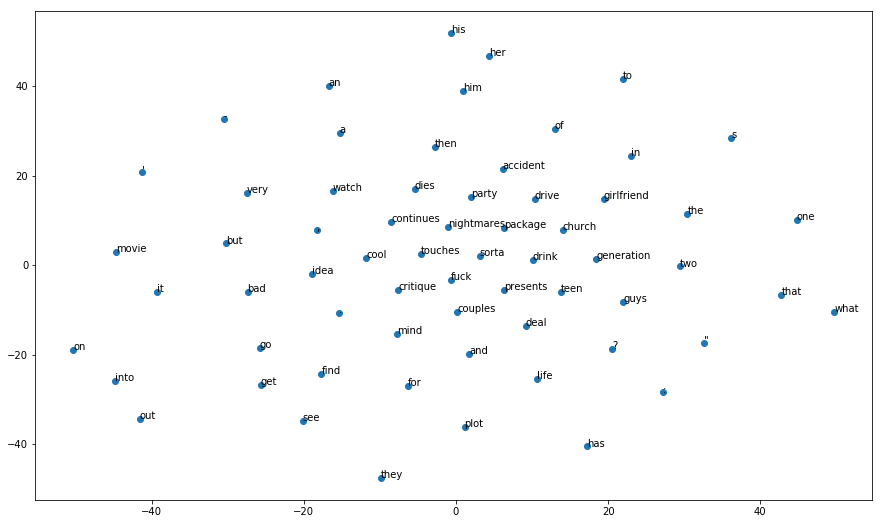

In [31]:
def plot_embeddings(w2v_model, target_terms):
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    term_vectors = []
    # let's make sure that a term we want is in the model
    for target_term in target_terms:
        if target_term in w2v_model.wv.vocab:
            term_vectors.append(w2v_model.wv[target_term])
    Y = tsne.fit_transform(term_vectors)
    
    # let's make this plot a decent size...
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width and height
    fig_size[0] = 15
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
 
    plt.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(target_terms, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()
    
max_movie_sentences_to_visualize = 8
visualization_terms = set()
for sentence in movie_reviews.sents()[:max_movie_sentences_to_visualize]:
    for token in sentence:
        visualization_terms.add(token)
    
plot_embeddings(movie_model, list(visualization_terms))

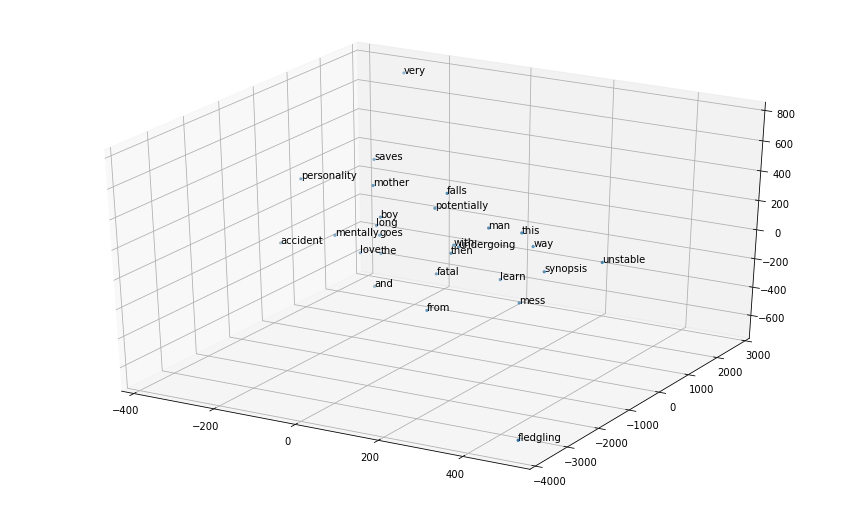

In [32]:
def plot_embeddings_3d(w2v_model, target_terms, min_word_length = 2):
    from mpl_toolkits.mplot3d import Axes3D
    tsne = TSNE(n_components=3, random_state=0)
    np.set_printoptions(suppress=True)
    term_vectors = []
    filtered_terms = []
    # let's make sure that a term we want is in the model
    for target_term in target_terms:
        # make sure that we're either not filtering or its above a certain length
        if min_word_length < 0 or len(target_term) > min_word_length:
            if target_term in w2v_model.wv.vocab:
                term_vectors.append(w2v_model.wv[target_term])
                filtered_terms.append(target_term)
    Y = tsne.fit_transform(term_vectors)
    
    # let's make this plot a decent size...
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width and height
    fig_size[0] = 15
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
 
    fig = plt.gcf()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(Y[:,0], Y[:,1], Y[:,2], marker='.')
    for i, word in enumerate(filtered_terms):
        ax.text(x=Y[i,0], y=Y[i,1], z=Y[i,2], s=word)
    plt.show()
    
max_movie_sentences_to_visualize = 5
visualization_terms = set()
for sentence in movie_reviews.sents()[105:107]:
    for token in sentence:
        visualization_terms.add(token)
    
plot_embeddings_3d(movie_model, list(visualization_terms))

{'out', 'their', 'shan', 'where', 'below', 'should', 'll', "hasn't", "you'd", 'than', 'after', 'can', 'themselves', "you've", 'herself', 'yours', 'few', 'having', 'off', 'mustn', 'he', 'has', 'under', 'an', 'am', 'did', 'hasn', 'up', 'do', 'himself', 'haven', "should've", 'me', 'does', 'any', "shan't", 'mightn', 'in', 'have', 'some', 'aren', 'here', 'you', 'again', 'the', 'y', "it's", 'yourself', 'that', "you'll", 'are', "she's", "couldn't", "that'll", 'to', "mustn't", 'for', 'i', 'is', 'now', 'until', 'about', 'needn', 'wasn', 'or', 'further', 'own', 'd', 're', 'its', 'hers', 'no', 'just', 'which', 'yourselves', 'theirs', 'we', 'with', 'was', 'not', 'during', 'and', 'this', 'were', "wouldn't", 've', 'so', 'but', 'them', 'being', 'too', 'ma', 'weren', 'on', 'what', 'how', 'will', "isn't", 'before', "won't", "doesn't", 'only', 'very', 'didn', 'when', 'ours', 'at', 'won', 'ain', 'be', "shouldn't", 'same', 'whom', 'if', 'it', 'o', 'most', 'through', 'doesn', 'shouldn', 'his', 'our', 'over

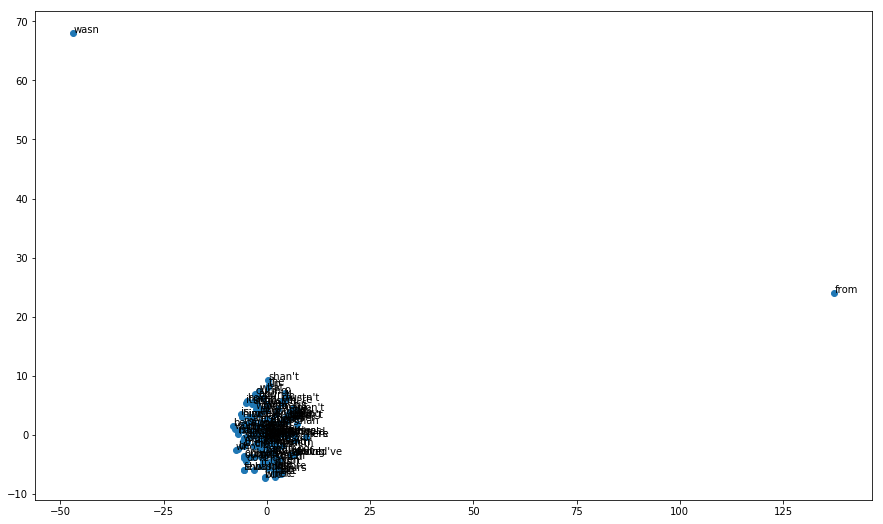

In [33]:
# here are some terms we can plot...
english_stop_words = set(nltk.corpus.stopwords.words('english'))
print(english_stop_words)
plot_terms = english_stop_words
plot_embeddings(movie_model, plot_terms)

# Now let's try to use these embeddings to do some classification. 

In [46]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, w2v_model):
        self.w2v_model = w2v_model
        self.vocab_size = len(w2v_model.wv.vocab)

    def fit(self, X, y):
        return self

    def transform(self, X):
        # this one uses the mean()
        return np.array([
            np.mean([self.w2v_model.wv[w] for w in words if w in self.w2v_model.wv]
                    or [np.zeros(self.vocab_size)], axis=0)
            for words in X
        ])
    
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.wv.vocab)

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec.wv[w] * self.word2weight[w]
                         for w in words if w in self.word2vec.wv] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])
    
class MaxEmbeddingVectorizer(object):
    def __init__(self, w2v_model):
        self.w2v_model = w2v_model
        self.vocab_size = len(w2v_model.wv.vocab)

    def fit(self, X, y):
        return self

    def transform(self, X):
        # this one uses the max()
        return np.array([
            np.max([self.w2v_model.wv[w] for w in words if w in self.w2v_model.wv]
                    or [np.zeros(self.vocab_size)], axis=0)
            for words in X
        ])
    
class TextTransformer(object):
    def __init__(self):
        self.initialized = True

    def fit(self, X, y):
        return self

    def transform(self, X):
        # this one uses the mean()
        return [' '.join(sentence) for sentence in X]

In [35]:
lr_mean_w2v = Pipeline([
    ("word2vec mean vectorizer", MeanEmbeddingVectorizer(movie_model)),
    ("Logistic Regression", LogisticRegression())
])

lr_max_w2v = Pipeline([
    ("word2vec max vectorizer", MaxEmbeddingVectorizer(movie_model)),
    ("Logistic Regression", LogisticRegression())
])

lr_tfidf_w2v = Pipeline([
    ("word2vec TF-IDF vectorizer", TfidfEmbeddingVectorizer(movie_model)),
    ("Logistic Regression", LogisticRegression())
])

In [36]:
X = [movie_reviews.words(fileid) for fileid in movie_reviews.fileids()]
# these are the categories
y_categories = [movie_reviews.categories(fileid)[0] for fileid in movie_reviews.fileids()]
# this maps the strings to 1 -> positive 0 -> negative (anything else)
y = [1 if category == 'pos' else 0 for category in y_categories ]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 777)

In [37]:
lr_mean_w2v.fit(X_train,y_train)

mean_w2v_f1 = f1_score(y_test, lr_mean_w2v.predict(X_test))
print('Word2Vec mean embeddings F1 : {}'.format(mean_w2v_f1))

Word2Vec mean embeddings F1 : 0.6913580246913581


In [38]:
lr_max_w2v.fit(X_train,y_train)

max_w2v_f1 = f1_score(y_test, lr_max_w2v.predict(X_test))
print('Word2Vec max embeddings F1 : {}'.format(max_w2v_f1))

Word2Vec max embeddings F1 : 0.5226666666666666


In [39]:
lr_tfidf_w2v.fit(X_train,y_train)

tfidf_w2v_f1 = f1_score(y_test, lr_tfidf_w2v.predict(X_test))
print('Word2Vec TF-IDF weighted embeddings F1 : {}'.format(tfidf_w2v_f1))

Word2Vec TF-IDF weighted embeddings F1 : 0.685


# Let's also compare against a bag of words pipeline

In [55]:
# set up a simple bag of words model
bow_pipeline = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', LogisticRegression()),
])

X_train_text = [' '.join(sentence) for sentence in X_train]
X_test_text = [' '.join(sentence) for sentence in X_test]
bow_pipeline.fit(X_train_text,y_train)

bow_f1 = f1_score(y_test, bow_pipeline.predict(X_test_text))
print('Bag of Words F1 : {}'.format(bow_f1))
print('BOW + W2V AUC : {}'.format(roc_auc_score(y_test, bow_pipeline.predict_proba(X_test_text)[:,1])))

Bag of Words F1 : 0.7804878048780488
BOW + W2V AUC : 0.8763477173233271


In [41]:
CLUSTER_FILE_PATH = 'corpus_cluster_map.pickle'
word_cluster_map = None
with open(CLUSTER_FILE_PATH, 'rb') as f:
    word_cluster_map = pickle.load(f)
    
print('Word cluster map size : {}'.format(len(word_cluster_map)))

Word cluster map size : 32666


In [42]:
%%time

def transform_tokens_to_clusters(sentences, word_cluster_map, unknown_token = 'UNK'):
    clustered_sentences = []
    for sentence in sentences:
        clustered_sentence = []
        for token in sentence:
            cluster = unknown_token
            if token in word_cluster_map:
                cluster = str(word_cluster_map[token])
                
            clustered_sentence.append(cluster)
            
        clustered_sentences.append(clustered_sentence)
        
    return clustered_sentences

X_train_clustered = transform_tokens_to_clusters(X_train, word_cluster_map)
X_test_clustered = transform_tokens_to_clusters(X_test, word_cluster_map)

print('Size of clustered TRAIN set : {}'.format(len(X_train_clustered)))
print('Size of clustered TEST set : {}'.format(len(X_test_clustered)))

Size of clustered TRAIN set : 1600
Size of clustered TEST set : 400
Wall time: 2.7 s


In [43]:
# set up a simple bag of words model
cluster_pipeline = Pipeline([('vect', CountVectorizer(ngram_range = (1,3))),
                      #('tfidf', TfidfTransformer()),
                      ('clf', LogisticRegression()),
])

X_train_clustered_text = [' '.join(sentence) for sentence in X_train_clustered]
X_test_clustered_text = [' '.join(sentence) for sentence in X_test_clustered]
cluster_pipeline.fit(X_train_clustered_text,y_train)

cluster_f1 = f1_score(y_test, cluster_pipeline.predict(X_test_clustered_text))
print('Word Cluster F1 : {}'.format(cluster_f1))

Word Cluster F1 : 0.7317073170731707


In [54]:
combined_pipeline = Pipeline([
                        # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the post's subject line
            ('bow', Pipeline([
                ('text', TextTransformer()),
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer())
            ])),

            # Pipeline for standard bag-of-words model for body
            ('mean_w2v', Pipeline([
                ("word2vec mean vectorizer", MeanEmbeddingVectorizer(movie_model))
            ])),
        ],
    )),
    ('clf', LogisticRegression()),
])

combined_pipeline.fit(X_train,y_train)

combined_f1 = f1_score(y_test, combined_pipeline.predict(X_test))
print('BOW + W2V F1 : {}'.format(combined_f1))
print('BOW + W2V AUC : {}'.format(roc_auc_score(y_test, combined_pipeline.predict_proba(X_test)[:,1])))

BOW + W2V F1 : 0.7574257425742574
BOW + W2V AUC : 0.8265666041275797
